# Demo de implementación de un algoritmo de Bandadas de Pájaros (Particle Swarm Optimization o PSO) para resolver el problema de encontrar un Máximo Óptimo definido al azar en un plano y tratando de esquivar los máximos locales aleatorios
El código es una adaptación del ejemplo de la librería DEAP disponible en https://deap.readthedocs.io/en/master/ pero no utiliza la librería (no son necesarios los operadores ni clases) y se mejora

1) Importar librerías:

In [1]:
#@title
import random
import math
import numpy as np
import matplotlib.pyplot as plt

import operator
import copy
print("\nLibrerías importadas")


Librerías importadas


2) Establecer parámetros generales de la Corrida:

In [2]:
# Cantidad de Máximos Locales
CANT_MAXIMOS_LOCALES = 3 #@param {type:"slider", min:0, max:10, step:1}

# Espacio mínimo y máximo del espacio de búsqueda
MIN_ESPACIO_BUSQ = -1000 #@param {type:"slider", min:-1000, max:0, step:5}
MAX_ESPACIO_BUSQ = 1000 #@param {type:"slider", min:0, max:1000, step:10}

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 100 #@param {type:"integer"}

# Cantidad de Particulas
CANT_PARTICULAS = 10 #@param {type:"slider", min:1, max:50, step:1}

# Indica si se muestra el detalle de cada ciclo
MUESTRA_DETALLE = True #@param {type:"boolean"}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


3) Especificar el objeto Particula y la Función Heurística:

In [3]:
#@title clase MAPA DE BÚSQUEDA

class MapaBusqueda(object):

    def __init__(self, limMin, limMax, cantMaximosLocales=0):
          self.limMin = limMin
          self.limMax = limMax
          self.cantMax = cantMaximosLocales
          self.generarPosicionesRnd()

    def generarPosicionesRnd(self):
      
        # Define Posiciones Random para Máximos Locales y Óptimos
        # con Heurística también al Azar (entre 1 y 100)
        # controla que el máximo local/global no se ubique en la misma posición que el Hormiguero
        self.MaximosPos = []
        self.MaximosVal = []
        self.MaxOptimoID = 0
        auxMejorVal = -99
        i = 0
        while len(self.MaximosPos)<(self.cantMax+1):

            auxPos = [ random.randint(self.limMin, self.limMax),  random.randint(self.limMin, self.limMax) ]        
            auxVal = random.randint(-20, 100)

            self.MaximosPos.append( auxPos )
            self.MaximosVal.append( auxVal )
            
            if self.MaximosVal[self.MaxOptimoID] < auxVal:
                self.MaxOptimoID = i
            i= i + 1

        return True
   
    def printInformacion(self):
        # Muestra la información sobre el Mapa de Búsqueda
        print("\n** Máximos Generados: ", len(self.MaximosPos))
        for auxPos, auxVal in zip(self.MaximosPos, self.MaximosVal):
            print("  -->", auxPos, "{ ", auxVal, " } ")
        print("\n** Posición Máximo Óptimo: ", self.MaximosPos[self.MaxOptimoID], " { ",  self.MaximosVal[self.MaxOptimoID]," } **")
        print("\n")

    @property
    def posMaximos(self):
        return self.MaximosPos    

    @property
    def valMaximos(self):
        return self.MaximosVal   
        
    @property
    def posMaximoGlobal(self):
        return self.MaximosPos[self.MaxOptimoID]         
    
    @property
    def valMaximoGlobal(self):
        return self.MaximosVal[self.MaxOptimoID]  

    def estaEnMaximo(self, posicion):
      # Indica si la posición corresponde o no a un Máximo 
      # si es verdadero devuelve el valor correspondiente, sino 0
      for i in range(len(self.MaximosPos)):
        if posicion==self.MaximosPos[i]:
          return self.MaximosVal[i]
      return 0

    def funcHeuristica(self, posicion):
        # Define la Función Heurística para evaluar una posicion del mapa
        devuelve = 0
        disPosMenor = self.limMax
        for posMax, valMax in zip(self.MaximosPos, self.MaximosVal):

              # calcula la distancia al punto de la Particula
              sqerrors = ((x - y)**2 for x, y in zip(posicion, posMax))
              distPos =  math.fsum(sqerrors)**0.5 / 10
              
              # Si es la menor distancia calcula la Heurística
              if disPosMenor > distPos:
                  disPosMenor = distPos 
                  devuelve = ( valMax - distPos) 

          # Por las dudas controla que devuelva un valor positivo
        return max(devuelve,0)


print("\nClase Mapa de Búqueda definida") 


Clase Mapa de Búqueda definida


In [4]:
#@title clase PARTICULA

class Particula(object):
    
    def __init__(self, mapa):        
        self.mapa = mapa
        self.pos = [random.randint(self.mapa.limMin, self.mapa.limMax) for _ in range(2)]
        self.valor = self.mapa.funcHeuristica(self.pos)
        self.velocidad = [random.uniform(self.mapa.limMin//10, self.mapa.limMax//10) for _ in range(len(self.pos))]
        

    def _reset(self):
        self.pos = []
        self.valor = -9999
        self.velocidad = []

    @property
    def heuristica(self):
        return round(self.valor, 2)

    @property
    def posicion(self):
        return self.pos   

    def moverse(self, mejorCiclo, mejorCorrida, coefAtraccMejorCiclo=1.5, coefAtraccMejorCorrida=3):
        
        for i in range(len(self.pos)):
              # calcula el desplazamiento (velocidad) en base a la atracción a la mejor del ciclo y global
            ajusteVel = (coefAtraccMejorCiclo * random.uniform(0, 1) * (mejorCiclo.posicion[i]-self.pos[i])) \
                        + (coefAtraccMejorCorrida * random.uniform(0, 1) * (mejorCorrida.posicion[i]-self.pos[i]))
            self.velocidad[i] = self.velocidad[i] + ajusteVel/10

              # ajusta la posición de la partícula (se ajusta la velocidad para que cambie de a poco)
            self.pos[i] = self.pos[i] + int(self.velocidad[i])

              # revisa no haber superado los límites del mapa
            if self.pos[i] < self.mapa.limMin:
                  self.pos[i] = self.mapa.limMin
            elif self.pos[i] > self.mapa.limMax:
                  self.pos[i] = self.mapa.limMax

          # actualiza su heurística
        self.valor = self.mapa.funcHeuristica(self.pos)
        return copy.deepcopy( self.pos )

print("\nClase Particula definida")


Clase Particula definida


4) Ejecutar la corrida del algoritmo mostrando resultados:

In [5]:
#@title INICIALIZA EL MAPA DE BÚSQUEDA

# Define el Mapa de Búsqueda
mapa = MapaBusqueda(limMin=MIN_ESPACIO_BUSQ, limMax=MAX_ESPACIO_BUSQ, \
                    cantMaximosLocales=CANT_MAXIMOS_LOCALES)

print("\nMapa de búsqueda definido")


Mapa de búsqueda definido


In [6]:
#@title EJECUCIÓN DE LA CORRIDA

# Muestra su información
mapa.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1
print("-- Mínima heurística para finalizar la Corrida: ", MIN_HEURISTICA_FINALIZAR, "--")

# vectores auxiliares 
ciclo = 1    
mejorPartCiclo = None
mejorPartCorrida = None
ciclosParticulas = []
ciclosMaxAptitud = []
partPobla = []

# Define la población de las Particulas
ciclosParticulas.append( [] )
for i in range(CANT_PARTICULAS):
  p = Particula(mapa)
  partPobla.append( p ) 
  ciclosParticulas[0].append( copy.deepcopy( p.posicion ) )

# Finaliza cuando llegue a la cantidad de ciclos 
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorPartCiclo==None) or mejorPartCorrida.heuristica<MIN_HEURISTICA_FINALIZAR):

    if MUESTRA_DETALLE:
        print("\n-- Ciclo  %i --" % ciclo)        

    # Evalúa las particulas de la población para determinar las mejores 
    rankingParticulas = sorted(partPobla, key=operator.attrgetter('heuristica'), reverse=True)
    mejorPartCiclo = rankingParticulas[0]
    if mejorPartCorrida == None or mejorPartCiclo.heuristica > mejorPartCorrida.heuristica:
        # congela la particula con la mejor posición encontrada en la corrida
        mejorPartCorrida = copy.deepcopy( mejorPartCiclo ) 
    ciclosMaxAptitud.append( rankingParticulas[0].heuristica )

    if MUESTRA_DETALLE:
        print(" Mejor Partícula Ciclo:", mejorPartCiclo.posicion, " { ", mejorPartCiclo.heuristica, " } ")
        print(" Mejor Partícula Corrida:", mejorPartCorrida.posicion, " { ", mejorPartCorrida.heuristica, " } ")

    # Actualiza la posición de las partículas
    ciclosParticulas.append( [] )
    for p in partPobla:
        nuevaPos = p.moverse( mejorPartCiclo, mejorPartCorrida )
        ciclosParticulas[ciclo].append( nuevaPos )

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )
print("** Posición Máximo Óptimo a Buscar: ", mapa.posMaximoGlobal, " { ",  mapa.valMaximoGlobal," } **")
print("== Mejor Partícula de la Corrida:", mejorPartCorrida.posicion, " { ", mejorPartCorrida.heuristica, " } ==")


** Máximos Generados:  4
  --> [-588, 342] {  46  } 
  --> [-847, 483] {  76  } 
  --> [792, 453] {  42  } 
  --> [-606, -40] {  15  } 

** Posición Máximo Óptimo:  [-847, 483]  {  76  } **


-- Mínima heurística para finalizar la Corrida:  75 --

-- Ciclo  1 --
 Mejor Partícula Ciclo: [-871, 594]  {  64.64  } 
 Mejor Partícula Corrida: [-871, 594]  {  64.64  } 

-- Ciclo  2 --
 Mejor Partícula Ciclo: [-936, 664]  {  55.83  } 
 Mejor Partícula Corrida: [-871, 594]  {  64.64  } 

-- Ciclo  3 --
 Mejor Partícula Ciclo: [-771, 493]  {  68.33  } 
 Mejor Partícula Corrida: [-771, 493]  {  68.33  } 

-- Ciclo  4 --
 Mejor Partícula Ciclo: [-952, 476]  {  65.48  } 
 Mejor Partícula Corrida: [-771, 493]  {  68.33  } 

-- Ciclo  5 --
 Mejor Partícula Ciclo: [-907, 554]  {  66.7  } 
 Mejor Partícula Corrida: [-771, 493]  {  68.33  } 

-- Ciclo  6 --
 Mejor Partícula Ciclo: [-892, 523]  {  69.98  } 
 Mejor Partícula Corrida: [-892, 523]  {  69.98  } 

-- Ciclo  7 --
 Mejor Partícula Ciclo: [-818

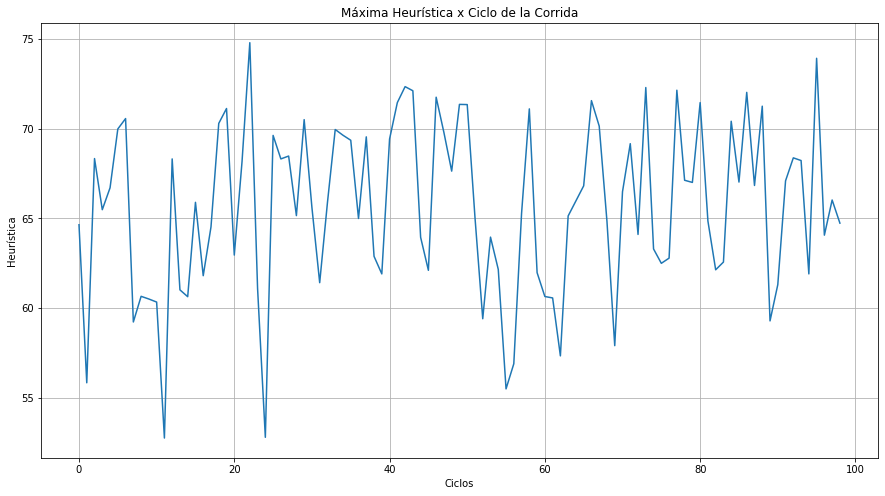

In [7]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8)) 
plt.plot(ciclosMaxAptitud)
plt.title('Máxima Heurística x Ciclo de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Heurística')
plt.grid(True)
plt.show()

In [8]:
#@title MOSTRAR GRAFICO DEL MOVIMIENTO DE LAS PARTICULAS CICLO x CICLO

# Librerías especiales para usar
from matplotlib import animation, rc
from IPython.display import HTML

# Define la configuración para el gráfico
MOSTRAR_HISTORICO_MOVIMIENTO = False
textoTitulo = "Movimiento de las Partículos ciclo x ciclo"
textoDesc = '\n** Posición Máximo Óptimo a buscar : ' + str(mapa.posMaximoGlobal) + ' { ' +  str(mapa.valMaximoGlobal) +' } **'
textoDesc = textoDesc + '\n== Mejor Partícula de la Corrida: ' + str(mejorPartCorrida.posicion) + ' { ' + str(round(mejorPartCorrida.heuristica, 3)) + ' } =='
textoDesc = textoDesc + '\n-- Colores:  Máximos Locales (AZUL) - Máximo Óptimo (VERDE) - '  
textoDesc = textoDesc + '\n- Partículas (ROJO) - Mejor Partícula (VIOLETA) -- ' 
posMejorCorrida =  mejorPartCorrida.posicion
ax = None
ani = None

# Método que se ejecuta por cada frame para mostrar 
def updatePlot(i, ciclosPos, scat):

        if ax==None or ciclosPos==None:
            return scat, 

        ax.set_xlabel('Ciclo: ' + str(i), fontsize=12)

          # Si no es el último ciclo, muestra también el global
        if i<len(ciclosPos): 
        
          if len(ciclosPos[i])>0:
             
              if MOSTRAR_HISTORICO_MOVIMIENTO:
                  # Coloca nuevas posiciones correspondientes al ciclo
                  # Separa las coordenadas x, y de las posiciones en el ciclo i
                  X, Y = zip(*ciclosPos[i])
                  ## --en Rojo: posiciones de las particulas de cada ciclo
                  scat = ax.scatter(X, Y, color='red')
              else:
                  # Hace mover a las Partículas
                  scat.set_offsets(ciclosPos[i])
        else:
               if posMejorCorrida != None:
                      ## --en Violeta: Mejor posición de las partículas
                      ax.scatter(posMejorCorrida[0], posMejorCorrida[1], color='violet', s=100)

        # Devuelve una lista de "artistas" para dibujar, 
        # en este caso es sólo uno por lo que se pone una coma final
        return scat,    

# Función para preparar el gráfico          
def PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosPos, textoTitulo="", textoDesc=""):          
     
      fig = plt.figure(figsize=(14,7))
      ax = fig.add_subplot(111)
      plt.close()

      ## -- en Azul: Máximos Locales (positivos)
      ## -- en Cyan: Mínimos Locales (negativos)
      ## -- en Verde: Máximo Óptimo
      for posi, vali in zip(mapa.posMaximos, mapa.valMaximos):    
        if vali < 0:
            ax.scatter(posi[0], posi[1], color='cyan')
        else:
            ax.scatter(posi[0], posi[1], color='blue')
      ax.scatter(mapa.posMaximoGlobal[0], mapa.posMaximoGlobal[1], color='green', s=150)    

      # Define el tamaño de la figura
      ax.axis([MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ])

      # Separa las coordenadas x, y de las posiciones en el ciclo inicial
      X, Y = zip(*ciclosPos[0])
      ## --en Rojo: posiciones de las posiciones de cada ciclo
      scat = ax.scatter(X, Y, color='red')

      # Muestra título y texto debajo
      ax.set_title(textoTitulo)
      ax.set_ylabel(textoDesc, fontsize=11)

      # Luego setea la animación usando los dos métodos anteriores 
      cant = len(ciclosPos)+1
      ani = animation.FuncAnimation(fig, updatePlot, 
                                    frames=cant, interval=cant,
                                    fargs=(ciclosPos, scat), 
                                    blit=True, repeat=False)
      
      return ani, ax
    


# Prepara el gráfico 
ani, ax = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosParticulas, textoTitulo, textoDesc)    

# Nota: esto se agega para que funcione en Google Colab
rc('animation', html='jshtml')
ani


In [ ]:
#@title EXPORTA EL GRAFICO ANTERIOR COMO UN VIDEO MP4
from google.colab import files

# Prepara el gráfico 
ani, ax = PrepararGrafico(mapa, MIN_ESPACIO_BUSQ, MAX_ESPACIO_BUSQ, ciclosParticulas, textoTitulo, textoDesc)

# Graba el gráfico anterior como un video MP4
nomArchi = "PSO Corrida.mp4"
ani.save('/' + nomArchi)
try: 
  files.download('/' + nomArchi)
  print('Video ' + nomArchi + ' generado, debería bajarse automaticamente como un archivo local...')
except ValueError:
  print('Error al intentar descargar el archivo ' + nomArchi)